## Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00025: Introduction to Vibration Theory


### Class 12 - Forced vibration of multi degree of freedom systems

[1.   The Rayleigh quotient](#section_1)  
[2.   The damping matrix](#section_2)  
[3.   Modal superposition](#section_3)  
[4.   Application: seimic response](#section_4)  
[5.   Number of modes to be considered](#section_5)  
[6.   Modal analysis for static response](#section_6)  
[7.   Static equivalent loads](#section_7)  

---
_Prof. Marcelo M. Rocha, Dr.techn._ [(ORCID)](https://orcid.org/0000-0001-5640-1020)  
_Porto Alegre, RS, Brazil_ 


In [1]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)

import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
from MRPy import MRPy

# Load matrices generated in Class 10 and 11 (those notebooks must be run firstly!)

with open('resources/data/sample_KM.pk', 'rb') as target:  # mass and stiffness matrices
    K1, M1, K2, M2, K3, M3 = pk.load(target)

with open('resources/data/sample_VM.pk', 'rb') as target:  # modal properties
    wk1, Phi1, wk2, Phi2, wk3, Phi3 = pk.load(target)


## 1. The Rayleigh quotient <a name="section_1"></a> 

In a previous class we have seen that for a discrete system the potential
elastic and the kinetic energy can be given in matrix notation as:

\begin{align*}
 V &= \frac{1}{2} \; \vec{u}^{\intercal} \mathbf{K} \,\vec{u} \\
 T &= \frac{1}{2} \; \dot{\vec{u}}^{\intercal} \mathbf{M} \, \dot{\vec{u}}
\end{align*}

These expressions are valid both for each (finite) element, as for the complete system as well.
Now we recall the free vibration response in the $k$-th vibration mode and the corresponding velocity:

\begin{align*}
 \vec{u}_k(t)       &=          u_{k0} \sin \left( \omega_k t + \theta_k \right) \, \vec{\varphi}_k \\
 \vec{\dot{u}}_k(t) &= \omega_k u_{k0} \cos \left( \omega_k t + \theta_k \right) \, \vec{\varphi}_k
\end{align*}

Disregarding any energy dissipation (damping), both energy forms, $V$ and $T$, must have the same 
maximum amplitude occurring whenever the sine or the cosine function peaks at unity: 

$$ \frac{V_{\rm max}}{T_{\rm max}} =  
 \frac{     u_{k0}^2 \; \left(\vec{\varphi}_k^{\intercal} \mathbf{K} \,\vec{\varphi}_k \right)}
{\omega_k^2 u_{k0}^2 \; \left(\vec{\varphi}_k^{\intercal} \mathbf{M} \,\vec{\varphi}_k \right)} = 1 $$

This means that:

$$ \omega_k^2 = \frac{V_{\rm max}}{T_{\rm max}^*} $$

where $T_{\rm max}^*$ is called _reference kinetic energy_, which is the kinetic energy calculated
with displacements instead of velocities. 

The equation above is called _Rayleigh Quotient_, and the equality holds only for free vibration at a given 
mode $k$, whatever the vibration amplitude $u_{k0}$ is.  
However, it can be shown that _any displacement vector, $\vec{u}$, that minimizes the quotient 
above IS a vibration mode_. 
This means that by making an educated guess about $\vec{u}_k$ for mode $\vec{\varphi}_k$ and calculating 
the corresponding energies, $V_{\rm max}$ and $T_{\rm max}^*$, will provide an estimation for $\omega_k$ 
that is equal or larger the correct value.

In the following example, we use the deformed shape for a central load calculated with FTool for the
plane truss (example 1) in [Class 10](https://nbviewer.jupyter.org/github/mmaiarocha/PEC00025/blob/master/Class_10_FromSingleToMany.ipynb?flushcache=true).
For the applied load of 1.0kN, the deformed shape is (the central line of the flexibility matrix):

<img src="images/truss12central.png" alt="Central load" width="780px"/>


In [2]:
uk = 1e-3*np.array([[0.1303, 0.2325, 0.2833, 0.2325, 0.1303]]).T    # initial guess for eigenvector (m)


The maximum potential elastic energy can be calculated as the work done by external forces, while the maximum
reference kinetic energy is calculated with the (lumped) mass matrix:


In [3]:
Vmax = 1000*uk[2,0]/2                         # work done by central load 1.0kN
Tref = np.dot(uk.T, np.dot(M1, uk))[0,0]/2    # reference kinetic with mass matrix

# Eigenvalue estimation
fk = np.sqrt(Vmax/Tref)/2/np.pi
f1 = wk1[0]/(2*np.pi)

print('From Rayleigh quotient:       {0:4.2f}Hz'.format(fk)) 
print('Calculated from eigenproblem: {0:4.2f}Hz'.format(f1))
print('Estimation error:             {0:4.2f}% '.format(100*(fk - f1)/f1))


From Rayleigh quotient:       4.02Hz
Calculated from eigenproblem: 3.94Hz
Estimation error:             2.02% 


This shows that the Rayleigh quotient may provide a very good estimation of natural frequencies whenever a 
convincing modal shape is assumed and the corresponding system stiffness is available.


## 2. The damping matrix <a name="section_2"></a> 

So far the natural frequencies and the corresponding modal shapes have been calculated without considering
any energy dissipation. It is however necessary to introduce a damping model, and we shall keep all the
mathematical convenience of viscous damping, that implies a reactive force proportional to velocity. 
In matrix notation the damped equilibrium equation is:

$$ {\mathbf M} \ddot{\vec{u}} + {\mathbf C} \dot{\vec{u}} + {\mathbf K} \vec{u} = \vec{F}(t) $$

In the next section we introduce the modal superposition method for solving linear systems subjected to
forced vibration. The method take advantage of the mode orthogonality with respect to both mass and stiffness
matrices. To keep this advantage for damped systems, the damping matrix must also respect the orthogonality
condition, what is a quite restrictive requirement. The most practical approach for ensuring this orthogonality
is defining the damping matrix as a linear combination of mass and stiffness:

$$ {\mathbf C} = \alpha_0 {\mathbf M} + \alpha_1 {\mathbf K} $$

This means that:


$$ C_k = \alpha_0 \left( \vec{\varphi}_k^{\intercal} {\mathbf M} \vec{\varphi}_k \right)  + 
         \alpha_1 \left( \vec{\varphi}_k^{\intercal} {\mathbf K} \vec{\varphi}_k  \right) = 
         \alpha_0 M_k + \alpha_1 K_k $$

where $C_k$, $M_k$ and $K_k$ are called modal damping, modal mass and modal stiffness, respectivelly.
Now we observe that the same definitions used for a one degree of freedom system can be applied to these 
modal properties: 

$$ C_k = 2 \zeta_k M_k \omega_k = \alpha_0 M_k + \alpha_1 M_k \omega_k^2 $$

Dividing all terms by $2 M_k \omega_k$ gives the modal damping ratio:

$$ \zeta_k = \alpha_0 \left( \frac{1}{2 \omega_k} \right) + \alpha_1 \left( \frac{\omega_k}{2} \right) $$

what means the modal damping can be estimated directly from the modal frequency, such that once two
pairs $(\zeta_i, \omega_i)$ and $(\zeta_j, \omega_j)$ are specified, the complete damping matrix is defined 
from the solution of an equation system for $\alpha_0$ and $\alpha_1$.

As an example, let us take the truss above and specify a damping ratio of 1% for the second and the fourth modes.
The calculation is done as shown below:


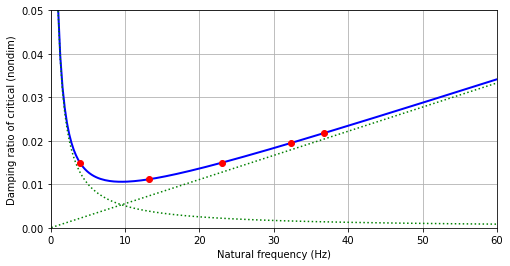

In [4]:
# Calculate the combination coefficients

wki = wk1[0];  zti = 0.015
wkj = wk1[2];  ztj = 0.015

alpha = np.linalg.solve([[1/(2*wki), wki/2], 
                         [1/(2*wkj), wkj/2]], [zti, ztj])

# Define damping as functions of frequency

ztM  = lambda fk: alpha[0]/(4*np.pi*fk)    # only M proportional
ztK  = lambda fk: alpha[1]*np.pi*fk        # only K proportional
ztMK = lambda fk: ztM(fk) + ztK(fk)        # mixed M and K model

# Visualize damping ratios for all vibration modes

fk1 = wk1/(2*np.pi)
fk  = np.linspace(0.1, 60, 200)

plt.figure(1, figsize=(8,4))
plt.plot(fk,  ztMK(fk ), 'b' , lw=2.0)
plt.plot(fk,  ztM (fk ), 'g:', lw=1.5)
plt.plot(fk,  ztK (fk ), 'g:', lw=1.5)
plt.plot(fk1, ztMK(fk1), 'ro')
plt.xlabel('Natural frequency (Hz)')
plt.ylabel('Damping ratio of critical (nondim)')
plt.axis([0, 60, 0, 0.05])

plt.grid(True)


One can conclude that damping ratios for all further modes are consequence of the specification of pairs
 $(\zeta_i, \omega_i)$ and $(\zeta_j, \omega_j)$, which must be wisely chosen. Frequencies inside the interval
 will present lower, outside higher damping ratios.
 
 There are other techniques for assembling a damping matrix that presents mathematical convenience, but any
 solution beyond the simple one presented above will result in complex eigenvalues and eigenvectors and will
 not be explored in this course.


In [5]:
Mk = np.dot(Phi1.T,np.dot(M1, Phi1))

q1 = Phi1[:,0]
print(q1)

for k in range(5):
    Phi1[:,k] = Phi1[:,k] / np.sqrt(Mk[k,k]) 
    
q1 = Phi1[:,0]
print(q1)

Mk = np.dot(Phi1.T,np.dot(M1, Phi1))

print(np.diag(Mk))


[0.2901579 0.4993386 0.5770084 0.4993386 0.2901579]
[0.00648813 0.01116555 0.0129023  0.01116555 0.00648813]
[1. 1. 1. 1. 1.]


## 3. Modal Superposition in time domain <a name="section_3"></a> 

We have seen how to solve the undamped matrix equilibrium equation for initial conditions 
$\vec{u}_0$ and $\vec{v}_0$. Now we will present the _most used method_ for solving the
damped equilibrium for any given load vector $\vec{F}(t)$:

$$ {\mathbf M} \ddot{\vec{u}} + {\mathbf C} \dot{\vec{u}} + {\mathbf K} \vec{u} = \vec{F}(t) $$

We start by recalling the time-space separation assumption:

$$ \vec{u}(t) = \sum_{k = 1}^{N} u_k(t) \, \vec{\varphi}_k = \mathbf{\Phi}\vec{u}_k(t) $$

which has led to the modal properties $\left( \omega_k, \vec{\varphi}_k \right)$. 
Replacing this assumption in the matrix equilibrium equation and pre-multiplying by 
${\mathbf \Phi}^{\intercal}$ gives:

$$ \left( {\mathbf \Phi}^{\intercal}{\mathbf M}{\mathbf \Phi} \right) \, \ddot{\vec{u}}_k + 
   \left( {\mathbf \Phi}^{\intercal}{\mathbf C}{\mathbf \Phi} \right) \,  \dot{\vec{u}}_k + 
   \left( {\mathbf \Phi}^{\intercal}{\mathbf K}{\mathbf \Phi} \right) \,       \vec{u}_k  =
          {\mathbf \Phi}^{\intercal} \vec{F}(t) $$

The orthogonality of matrix ${\mathbf \Phi}$ (the orthogonality of modal shapes $\vec\phi_k$)
leads to a decouple of the matrix equation, which becomes a system of $N$ scalar equations:

$$ \left( \vec\varphi_k^{\intercal}{\mathbf M} \vec\varphi_k \right) \, \ddot{u}_k + 
   \left( \vec\varphi_k^{\intercal}{\mathbf C} \vec\varphi_k \right) \,  \dot{u}_k + 
   \left( \vec\varphi_k^{\intercal}{\mathbf K} \vec\varphi_k \right) \,        u_k = 
    \vec\varphi_k^{\intercal} \vec{F}(t),
    \hspace{1cm} k = 1, 2, \dots, N   $$

where $M_k = \vec\phi_k^{\intercal}{\mathbf M} \vec\phi_k$,
$C_k = \vec\phi_k^{\intercal}{\mathbf C} \vec\phi_k$, and
$K_k = \vec\phi_k^{\intercal}{\mathbf K} \vec\phi_k$, are the so-called _modal mass_,
_modal damping_ and _modal stiffness_, respectively. 
The well known relation $K_k = \omega_k^2 M_k$ still holds.
Observe that the modal damping 
definitions is only possible if the orthogonality is forced as, for instance, shown
in the previous section.

Each dynamic equilibrium scalar equation:

$$ M_k \ddot{u}_k + C_k \dot{u}_k + K_k  u_k = F_k(t) $$

or

$$ \ddot{u}_k + 2\zeta_k\omega_k \dot{u}_k + \omega_k^2 u_k = F_k(t)/M_k $$

is the equation of a single degree of freedom system subjected to 
the _modal load_:

$$ F_k(t) = \vec\phi_k^{\intercal} \vec{F}(t) $$

It is very important to realize that the concept of _degree of freedom_
in the equation above does not refer to a the classical definition,
rather to a more broad _generalized_ definition. Here, a degree of
freedom is the _scale_ to be applied to each modal shape. 

After the $N$ scalar equations are solved, for instance by some
numerical method like the Duhamel integral, the _nodal_ displacements
can be recomposed and the structure can be designed for the maximum
strains or stresses resulting from the dynamic load, with the
ressonant response duly taken into account.


## 4. Example of application: seismic response <a name="section_4"></a> 

As an example of application, let us apply a base acceleration
in the 3-dof model described in the previous classes. We shall then
analyse the amplitude of peak response to this seismic loading.

$$ m \left(\ddot{u} + \ddot{u}_{\rm G} \right) + c \dot{u} + k u = 0 $$

Hence: 

$$ m \ddot{u} + c \dot{u} + k u =  -m a_{\rm G} $$

Firstly we load the acceleration record and build the load vector,
which is simply the ground acceleration multiplied by the mass of
each model mass:

<img src="images/ground_acceleration.png" alt="ground acceleration" width="600px"/>


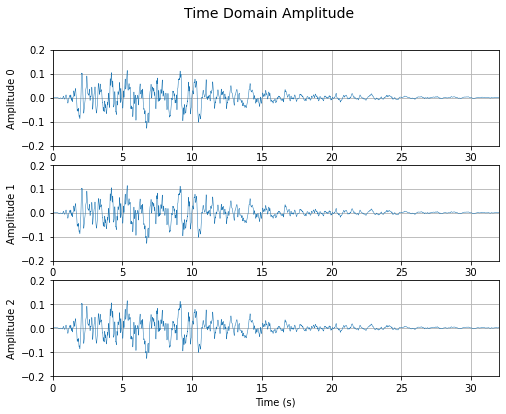

In [6]:
aG =  MRPy.from_file('resources/data/earthquake', form='columns')

FG =  np.dot(M3, np.tile(aG[0], (3,1)))
FG =  MRPy(-FG, fs=aG.fs)

f2 =  FG.plot_time(2, figsize=(8,6), axis_t=[0, aG.Td, -0.2, 0.2])


Be aware that these are _NODAL forces_.
The next step is to move the problem to modal space.
To have a orthogonal damping matrix we specify 1% damping 
for modes 1 and 3:


In [7]:
wki = wk3[0];  zti = 0.01
wkj = wk3[1];  ztj = 0.01

alpha = np.linalg.solve([[1/(2*wki), wki/2], 
                         [1/(2*wkj), wkj/2]], [zti, ztj])


Then we calculate the modal parameters and the modal forces:

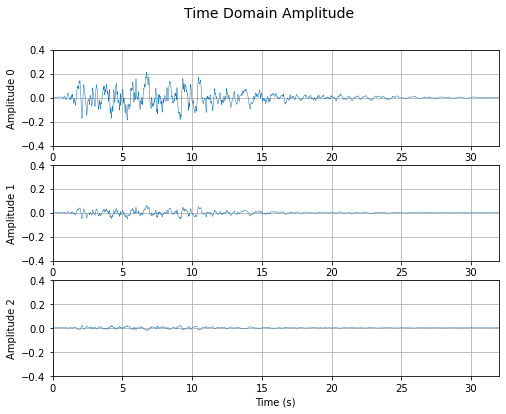

In [8]:
fk = wk3/(2*np.pi)
zk = ztMK(fk)

Mk = np.diag(np.dot(Phi3.T, np.dot(M3, Phi3)))
Kk = Mk*(wk3**2)
Fk = MRPy(np.dot(Phi3.T, FG), fs=FG.fs)

f3 = Fk.plot_time(3, figsize=(8,6), axis_t=[0, aG.Td, -0.4, 0.4])


Again, be aware that these are _MODAL forces_. 
The solution in modal space can be calculates using Duhamel, but first
the modal loads must be divided by the modal masses according to
the convention used for the ``sdof_Duhamel()`` method.


[0.00150316 0.00121104 0.00067584]


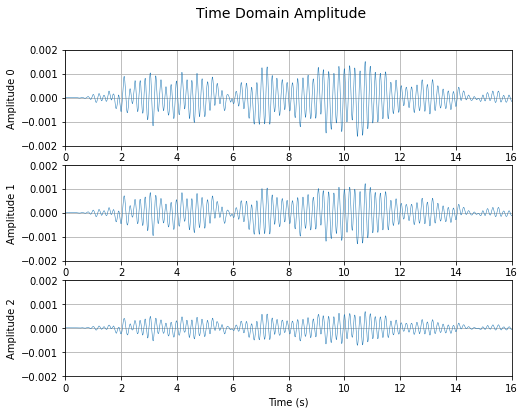

In [43]:
# Mass division must be a matrix operation...
ak = MRPy(np.dot(np.diag(1/Mk), Fk), fs=Fk.fs)

# ... and now solving
uk   = ak.sdof_Duhamel(fk, zk)             # modal space solution
utot = MRPy(np.dot(Phi3, uk), fs=uk.fs)    # nodal solution

f4   = utot.plot_time(4, figsize=(8,6), axis_t=[0, utot.Td/2, -0.002, 0.002])

upk  = utot.max(axis=1)
print(upk)


We can observe that the system response occurs mainly in the first mode.

<img src="images/model3dof_mode1.jpg" alt="model 3 dof first mode" width="180px"/>



## 5. Number of modes to be considered <a name="section_5"></a>

In the last section we have calculated the seismic response by 
superposing all three modes obtained from the 3-dof numerical model. However,
the main advantage of modal superposition is _exactly_ the possibility
of truncating the summation:

$$ \vec{u}(t) = \sum_{k = 1}^{M} u_k(t) \, \vec{\varphi}_k $$

to a number $M < N$ of relevant modes. In the previous example, if we had kept
only the first mode ($M = 1$) the result would be as shown below.
The error between considering all three modes and considering only
the first mode is plotted.


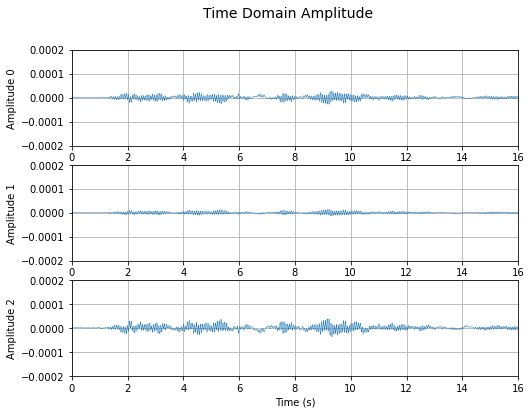

In [10]:
utot1 = np.zeros(uk.shape)            # allocating space for nodal response
qk1   = Phi3[:,0]                     # retrieve only first vibration mode

for k in range(3):
    utot1[k,:] = uk[0]*qk1[k]         # nodal response for each d.o.f.

err = MRPy(utot - utot1, uk.fs)           # error as a time series

f5  = err.plot_time(5, figsize=(8,6), axis_t=[0, utot.Td/2, -0.0002, 0.0002])


The result above shows that considering only the first vibration mode
(in the given example) will lead to a quite accurate result, with neglectable
error in comparison to the total response amplitude.

To decide what is the truncation $M < N$ suitable for any structural system,
let us recall the dynamic equilibrium equation:

$$ {\mathbf M} \ddot{\vec{u}} + {\mathbf C} \dot{\vec{u}} + {\mathbf K} \vec{u} = \vec{F}(t) $$

where we assume that the mass matrix is of lumped type (only diagonal 
elements are not zero) and the external force is defined as:

$$ \vec{F}(t) = -{\mathbf M} \vec{r} a_{\rm G}(t) $$

The column vector $\vec{r}$ (containing direction cosines) addresses the 
translational degrees of freedom that will receive the inertial load, 
according to the direction of ground acceleration. Rotational degrees of
freedom will be addressed with zero. 
For instance, in the 3-dof example the vector $\vec{r}$ contains 
only 1's, for all three structural nodes are subjected to $a_{\rm G}(t)$
(ground acceleration is assumed to be aligned to the three degrees
of freedom).

Applying modal decomposition to the matrix equation yields:

$$ M_k \ddot{u}_k + C_k \dot{u}_k + K_k  u_k = 
   -\left( \vec\varphi_k^{\intercal} {\mathbf M} \vec{r} \right) a_{\rm G}(t) $$


Now we defined a _modal seismic load factor_, a scalar quantity, as:

$$ L_k = \vec\varphi_k^{\intercal} {\mathbf M} \vec{r} $$

and divide the whole equation by the modal mass $M_k$:

$$ \ddot{u}_k + 2\zeta_k \omega_k \dot{u}_k + \omega_k^2 u_k = 
   -\left( \frac{L_k}{M_k} \right) a_{\rm G}(t) $$

It can be shown that:

$$ M_{\rm tot} = \sum_{k = 1}^{N}{\frac{L_k^2}{M_k}}$$

where $M_{\rm tot}$ is the system total mass (sum of all diagonal
elements of ${\mathbf M}$). Finally we define a _weightning factor_, 
$W_k$, such that:

$$ W_k = \frac{L_k^2 / M_k }{M_{\rm tot}} $$
 
which does not depend on the ground acceleration $a_{\rm G}(t)$, 
but depends on the addressing vector $\vec{r}$ and on the modal
shapes $\vec{\varphi}_k$.
The number of modes to be considered for truncation, $M$, must be 
such that the factors $W_k$ add up closely enough to unity.

For instance, let us calculate the weightning factors for the 
three modes of the previous example.


In [11]:
r3   = np.array([1, 1, 1])                        # addressing vector
Lk   = np.dot(np.dot(Phi3.T, M3), r3)             # modal factors
Mk   = np.diag(np.dot(np.dot(Phi3.T, M3), Phi3))  # modal masses

Mtot =  np.sum(np.diag(M3))                       # total mass
Wk   = (Lk**2)/Mk/Mtot                            # weightning factors

print('Weightning factor mode 1:  {0:5.4f}'.format(Wk[0]))
print('Weightning factor mode 2:  {0:5.4f}'.format(Wk[1]))
print('Weightning factor mode 3:  {0:5.4f}'.format(Wk[2]))


Weightning factor mode 1:  0.9141
Weightning factor mode 2:  0.0749
Weightning factor mode 3:  0.0110


This results explains why the first mode alone is capable of satisfactorily 
representing the complete system response. However, never forget that
this analysis depends on the addressing vector $\vec{r}$, that distributes
the load among the degrees of freedom, as well as on the the
modal shapes themselves.


## 6. Modal analysis for static response <a name="section_6"></a> 

It can be shown that the system flexibility matrix (the inverse of the
system stiffness matrix) can be reconstituted from vibration modes as:

$$ {\mathbf H}= {\mathbf K}^{-1} = \sum_{k = 1}^{N}
   {\frac{\vec\varphi_k \vec\varphi_k^{\intercal}}{\omega_k^2 M_k}}$$ 

Observe that each mode contributes to the full matrix as the product
$\vec\varphi_k \vec\varphi_k^{\intercal}$ has dimensions $N\times N$.
Recall also that the product $\omega_k^2 M_k$ is the modal stiffness,
$K_k$ for mode $k$.

If the summation in the equation above is truncated to only $M$ terms,
the flexibility matrix ${\mathbf K}^{-1}$ will be ill-conditioned and 
cannot be inverted to give the stiffness matrix, ${\mathbf K}$.
It can, however, be used to calculate an approximate static response
to any given load vector as: 

$$ \vec{u} = {\mathbf K}^{-1} \vec{F}$$

As an example of application, we will calculate the vertical displacement
of the central node in the plane truss subjected to self weight using
only the first modal shape. Recall that this result has been previously
calculated with Ftool as 20.48mm, while the same result using the 
condensed stiffness matrix was 20.18mm.

<img src="images/truss12loaded.png" alt="Isostatic truss" width="780px"/>

The first vibration mode is plotted below:


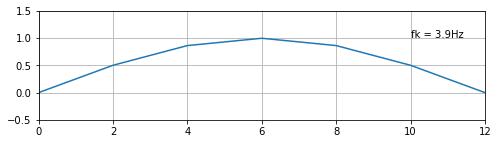

In [33]:
with open('resources/data/sample_VM.pk', 'rb') as target:  # modal properties
    wk1, Phi1, wk2, Phi2, wk3, Phi3 = pk.load(target)

f6 = plt.figure(6, figsize=(8,2))

qk = np.zeros(7)
qk[1:-1] = Phi1[:,0]                  # include supports for plotting
x  = np.arange(0, 14, 2)

#print(Phi1[:,0]/np.max(Phi1[:,0]))
#Phi1[:,0] = np.array([0.5, 0.75,  1, 0.5, 0.75])

plt.plot(x, qk/np.max(np.abs(qk)))    # normalize by unity
plt.axis([0, 12, -0.5, 1.5])
plt.text(10, 1, 'fk = {0:3.1f}Hz'.format(fk1[0]));
plt.grid(True)


Now we calculate modal properties and build up the (approximated) 
stiffness matrix and the load vector:


In [34]:
H1 = np.zeros(K1.shape)

for k in range(1):                    # choose how many modes to consider

    wk  = wk1[k]                      # fundamental frequency
    qk  = Phi1[:,k]                   # first mode
    Mk  = np.sum(qk*qk*np.diag(M1))   # modal mass (simplified calculation)
    Kk  = wk*wk*Mk                    # modal stiffness
    
    qk  = qk.reshape(5,1)             # prepare for matrix multiplication
    H1 += np.dot(qk,qk.T)/Kk          # approximated flexibility matrix
    
F  = 20000*np.ones((5,1))             # load vector (two nodes grouped)


Finally, the static displacement vector is calculated:

In [35]:
u  = np.matmul(H1, F)

print('Maximum displacement at truss center: {0:5.2f}'.format(1000*u[2,0]))


Maximum displacement at truss center: 20.32


We conclude that the displacement error at truss center is only 0.7% with respect to the 
solution with the condensed ${\mathbf K}$ matrix, which is an amazing result for such a simplification level
(only one degree of freedom).


## 7. Static equivalent loads <a name="section_7"></a> 

The dynamic response of a structure with $N$ degrees of freedom must be used for designing the structural elements 
according to the maximum stresses developed along time. This is not a simple task, for structural displacements
may be quite complex multivariate time series. 
A simple approach for finding the time instant when the largest stresses happen
may be monitoring the total potential elastic energy stored in the structure, which is easily calculated as:

$$ V = \frac{1}{2} \; \vec{u}^{\intercal} \mathbf{K} \,\vec{u} $$

If now we replace the modal decomposition for displacements, 

$$ V(t) = \frac{1}{2} \sum_{k = 1}^{N} u_k^2(t) \; \vec{\varphi}_k^{\intercal} \mathbf{K} \vec{\varphi}_k $$

and recognize that $\vec{\varphi}_k^{\intercal} \mathbf{K} \vec{\varphi}_k$ is the modal stiffness,
$K_k = \omega_k^2 M_k$, we finally get:

$$ V(t) = \frac{1}{2} \sum_{k = 1}^{N} \omega_k^2 M_k \, u_k^2(t) $$

which is a simple (always positive) sum of scalar time series. 
By searching for time $t_{\rm max}$ where $V(t)$ reaches a 
maximum, we finally get the displaced geometry associated to maximum stresses:

$$ \vec{u}_{\rm max} = \sum_{k = 1}^{N} u_k(t_{\rm max}) \, \vec{\varphi}_k $$

The sum above may be obviously truncated according to the required accuracy. Once the design displacement
is available, there is a _static equivalent load_ that may be specified for the structural designer, which
represents a virtual static load that causes the structure to be subjected to the same maximum deformation
occurring along the dynamic response.

$$ \vec{F}_{\rm eq} = {\mathbf K} \, \vec{u}_{\rm max} 
                    = \sum_{k = 1}^{N} u_k(t_{\rm max}) \, {\mathbf K} \, \vec{\varphi}_k$$

But again we recall the eigenvalue problem:

$$ \mathbf{K} \, \vec{\varphi}_k = \omega_k^2 \, \mathbf{M} \, \vec{\varphi}_k  $$ 

and the equivalent load can be writen as:

$$ \vec{F}_{\rm eq} = \sum_{k = 1}^{N}  \omega_k^2 u_k(t_{\rm max}) \, \mathbf{M} \vec{\varphi}_k$$

It is important to observe that there may be several deformed configurations, 
or several peak for time series $V(t)$,
leading to relevant loading conditions. 

As an example of application, let us go back to the seismic response analysis in section 4 and specify an
static equivalent load for the structural response. Firstly we take a look at the instantaneous elastic
potential energy.


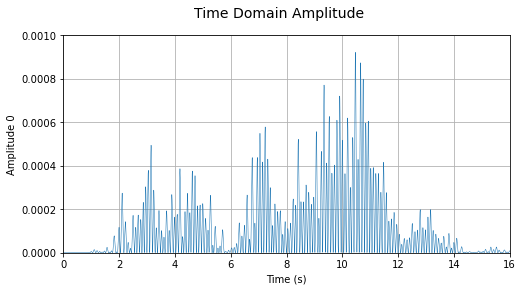

In [38]:
Mk = np.diag(np.dot(np.dot(Phi3.T, M3), Phi3))  # modal masses
Kk = wk3*wk3*Mk                                 # modal stiffnesses
V  = MRPy(uk*uk/2, fs=uk.fs).superpose(Kk)      # total elastic energy

f7 = V.plot_time(7, figsize=(8,4), axis_t=(0, uk.Td/2, 0, 0.001))


Then we look for the moment when $V(t)$ reaches a peak:


In [39]:
imax = np.argmax(V[0])
tmax = imax/uk.fs
umax = uk[:,imax]       # uk(tmax)

print('Time instant with maximum potential energy: {0:6.2f}s.'.format(tmax))

Time instant with maximum potential energy:  10.47s.


Finally, the static equivalent load is calculated:


In [42]:
Mqk = np.dot(M3, Phi3)
Feq = np.zeros(umax.shape)

#print(umax, umax.shape, Feq)

for k in range(3):
    Feq += wk3[k]*wk3[k]*umax[k]*Mqk[:,k]

    
ueq = np.linalg.solve(K3,Feq)
print(Feq)
print(ueq)


[-0.61147849 -0.48939257 -0.3031919 ]
[-0.00161579 -0.00129876 -0.00072798]


In [54]:
a = np.array([1,2,3,4,5,6])[::-1]
print(a)


[6 5 4 3 2 1]


### Assignment (2.2)

1. Apresentar uma estimativa da frequência fundamental através do quociente de Rayleigh.

2. Apresentar a resposta a um impulso unitário (estruturas horizontais: impulso vertical no centro; estruturas verticais: impulso horizontal no topo). Apresente o deslocamento no tempo para o nó que recebeu o impulso e o respectivo periodograma.

3. Calcular a força estática equivalente para a resposta ao impulso unitário e conferir no Ftool.
